In [2]:
# Description : This notebook is focused on building an artificial recurrent neural network calles LSTM 
# (Long Short Term Memory) to predict the closing price of a corporation using the past 60 days data. 

In [1]:
import math
import pandas as pd
import numpy as np
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
import yfinance as yf

In [2]:
today = date.today().strftime("%Y-%m-%d")
df = yf.download('MMM','2016-01-01',today)

[*********************100%***********************]  1 of 1 completed


In [3]:
print(f"Shape : {df.shape}")
print(df.tail())
print(df.info())

Shape : (1362, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-05-24  202.800003  203.520004  201.919998  202.610001  202.610001   
2021-05-25  202.850006  203.000000  201.369995  201.710007  201.710007   
2021-05-26  201.199997  201.789993  200.300003  201.580002  201.580002   
2021-05-27  203.000000  203.979996  202.619995  203.240005  203.240005   
2021-05-28  203.880005  204.389999  202.800003  203.039993  203.039993   

             Volume  
Date                 
2021-05-24  1529200  
2021-05-25  1519400  
2021-05-26  1847300  
2021-05-27  2457600  
2021-05-28  1741200  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1362 entries, 2015-12-31 to 2021-05-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1362 non-null   float64
 1   High       1362 non-null   float64
 2   Low        1362 non-

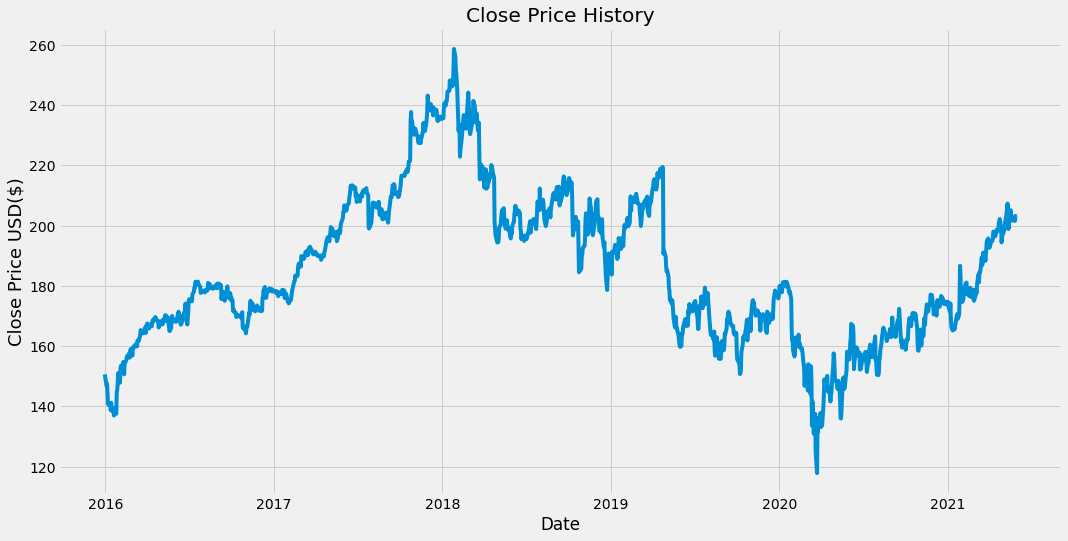

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1090

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(f"Raw Data : \n{dataset}")
print(f"Scaled Data : \n{scaled_data}")

Raw Data : 
[[150.63999939]
 [146.82000732]
 [147.46000671]
 ...
 [201.58000183]
 [203.24000549]
 [203.03999329]]
Scaled Data : 
[[0.23280759]
 [0.20566925]
 [0.210216  ]
 ...
 [0.59470018]
 [0.60649333]
 [0.60507239]]


In [7]:
train_data = scaled_data[0:training_data_len,:]
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1030, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1030/1030 [==============================] - 17s 15ms/step - loss: 0.0077


In [13]:
test_data = scaled_data[training_data_len-60:,:]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [14]:
x_test = np.array(x_test)

In [15]:
x_test

array([[0.31585677, 0.31983515, 0.29987211, ..., 0.2823245 , 0.27273367,
        0.24190107],
       [0.31983515, 0.29987211, 0.30036936, ..., 0.27273367, 0.24190107,
        0.21831488],
       [0.29987211, 0.30036936, 0.31670925, ..., 0.24190107, 0.21831488,
        0.21689394],
       ...,
       [0.42085818, 0.42760723, 0.42455244, ..., 0.59668938, 0.60201759,
        0.59562378],
       [0.42760723, 0.42455244, 0.44707303, ..., 0.60201759, 0.59562378,
        0.59470018],
       [0.42455244, 0.44707303, 0.46817278, ..., 0.59562378, 0.59470018,
        0.60649333]])

In [16]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.11642882403205423

<ipython-input-19-7aa66b8d0b79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


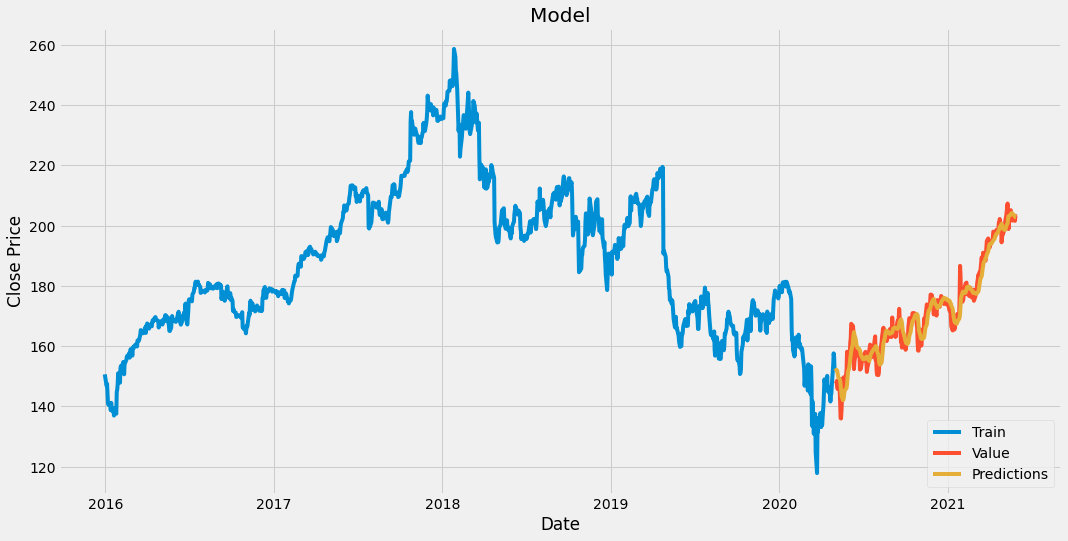

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Value','Predictions'],loc='lower right')
plt.show()

In [20]:
valid

,Close,Predictions
Date,,
2020-05-01,148.600006,151.688980
2020-05-04,148.399994,152.152328
2020-05-05,147.429993,152.033798
2020-05-06,146.199997,151.497208
2020-05-07,145.740005,150.655106
...,...,...
2021-05-24,202.610001,203.500397
2021-05-25,201.710007,203.282394
2021-05-26,201.580002,203.030930


In [24]:
apple_quote = df = yf.download('MMM','2010-01-01','2021-05-29')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price

[*********************100%***********************]  1 of 1 completed


array([[202.88834]], dtype=float32)

In [25]:
apple_quote_2 = yf.download('MMM','2021-05-30','2021-05-30')
apple_quote_2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,203.880005,204.392105,202.800003,203.039993,203.039993,1653168


In [142]:
apple_quote

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.471691,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.572422,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.583784,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.479061,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.467082,477131200
...,...,...,...,...,...,...
2021-05-18,126.559998,126.989998,124.779999,124.849998,124.849998,63342900
2021-05-19,123.160004,124.919998,122.860001,124.690002,124.690002,92612000
2021-05-20,125.230003,127.720001,125.099998,127.309998,127.309998,76857100
